# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [66]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

from datetime import datetime, timedelta
from getpass import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

from sklearn import svm

# Load functions 
from nasa_functions import *

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [33]:
# Get API key from user
api_key = getpass()

# API key (Frederik): 5moAl3aXJFGab03t4Rwyvnsb9UKRUSq5Tpu2aZYm
# API key (Nicole): KrcOIAM7hOjCyEN016pr35qkBVunND4DUBuzUXTE

# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=365)  # 1 year later


# Load data from NASA. 
data = get_data(api_key, start_date, end_date)


After downloading the data from the API we load the data into a dateframe using the json_to_dataframe function we have defined in the nasa_functions.py.

In [34]:
# Check the date there is contained in data
dates_contained_in_data = []
for d in data: dates_contained_in_data += list(d['near_earth_objects'].keys())

# Sort the dates so 2022-01-01 is first 
dates_contained_in_data = sorted(dates_contained_in_data)

# New empty dataframe
df_data = pd.DataFrame()

#Load the data from the json file to a pandas dataframe
json_to_dataframe(df_data, data, dates_contained_in_data)

df_data = df_data.apply(pd.to_numeric, errors='ignore')

# datastructure of the dataframe
df_data.head(5)    

,date,week,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,kilometers estimated_diameter_min,kilometers estimated_diameter_max,meters estimated_diameter_min,...,epoch_date_close_approach,relative_velocity kilometers_per_second,relative_velocity kilometers_per_hour,relative_velocity miles_per_hour,miss_distance astronomical,miss_distance lunar,miss_distance kilometers,miss_distance miles,orbiting_body,is_sentry_object
11,2022-01-01,0.0,2363505,2363505,363505 (2003 UC20),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2363505,18.52,0.525479,1.175006,525.478530,...,1.641000e+12,12.518531,45066.713121,28002.702939,0.157698,61.344390,2.359123e+07,1.465891e+07,Earth,False
12,2022-01-01,0.0,2376848,2376848,376848 (2001 RY47),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2376848,19.61,0.318094,0.711279,318.093633,...,1.641072e+12,17.701016,63723.656796,39595.402191,0.342086,133.071640,5.117541e+07,3.179892e+07,Earth,False
13,2022-01-01,0.0,2488490,2488490,488490 (2000 AF205),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2488490,21.90,0.110804,0.247765,110.803882,...,1.641052e+12,21.077399,75878.637808,47148.034698,0.407186,158.395382,6.091417e+07,3.785031e+07,Earth,False
14,2022-01-01,0.0,3388081,3388081,(2007 TL23),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3388081,21.48,0.134448,0.300635,134.448195,...,1.641059e+12,31.100974,111963.505363,69569.768096,0.197682,76.898348,2.957283e+07,1.837570e+07,Earth,False
15,2022-01-01,0.0,3592308,3592308,(2012 AP10),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3592308,26.50,0.013322,0.029788,13.321557,...,1.641063e+12,15.995934,57585.362913,35781.305083,0.397118,154.478962,5.940803e+07,3.691444e+07,Earth,False


For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

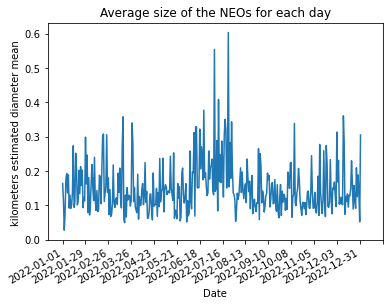

In [57]:
#### Average size of the NEOs for each day ####

# Size is the mean of estimated_diameter_min and estimated_diameter_max
df_data.loc[:, 'kilometers estimated_diameter_mean']=(df_data['kilometers estimated_diameter_min']+df_data['kilometers estimated_diameter_max'])/2
df_NEO_size_day_mean = df_data.groupby('date')['kilometers estimated_diameter_mean'].mean()

plt.plot(df_NEO_size_day_mean.index, df_NEO_size_day_mean)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,418,28))
plt.xlabel('Date')
plt.ylabel('kilometers estimated diameter mean ')
plt.title('Average size of the NEOs for each day')
plt.savefig('plots/NEO_size_day_mean.pdf')
plt.show()

The above graph shows the average size of the NEOs for each day. We can see that the size is bigger during the summer.

In [36]:
#### Proportion of NEOs that are potentially hazardous ####

# Get the status of the NEOs for each day
hazardous = list(df_data['is_potentially_hazardous_asteroid'])

# Count true and false values
true_count = hazardous.count(True)
false_count = hazardous.count(False)

# calculate the proportion
print('True counts: ',true_count)
print('False counts: ',false_count)
print('Percentage of true: ',(true_count/(true_count+false_count))*100)

True counts:  507
False counts:  7444
Percentage of true:  6.3765564079989945


The above data shows the proportion of NEOs that are potentially hazardous. We can see the percentage of potentially hazardous asteroid to non-potentially hazardous is only around 6.38%.

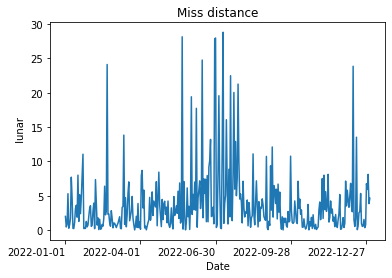

In [82]:

#### NEO with the closest approach distance for each day ####
df_dis_lunar_min = df_data.groupby('date')['miss_distance lunar'].min().astype('float')

plt.plot(df_dis_lunar_min.index, df_dis_lunar_min)
plt.xticks(rotation=0, ha='right', ticks=np.arange(0,418,90))
plt.xlabel('Date')
plt.ylabel(' lunar')
plt.title('Miss distance')
plt.savefig('plots/miss_distance.pdf')
plt.show()



The above graph shows the NEO with the closest approach distance for each day. We can see that the distance is relatively larger over the summer.

In [ ]:
#Descriptive statistics
df_data.describe()

,week,absolute_magnitude_h,kilometers estimated_diameter_min,kilometers estimated_diameter_max,meters estimated_diameter_min,meters estimated_diameter_max,miles estimated_diameter_min,miles estimated_diameter_max,feet estimated_diameter_min,feet estimated_diameter_max,epoch_date_close_approach,kilometers estimated_diameter_mean
count,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7951.000000,7.951000e+03,7951.000000
mean,26.500440,24.157607,0.092983,0.207916,92.982919,207.916127,0.057777,0.129193,305.062079,682.139547,1.657368e+12,0.150450
std,15.342266,2.731514,0.182580,0.408262,182.580165,408.261660,0.113450,0.253682,599.016308,1339.441183,9.280005e+09,0.295421
min,0.000000,14.680000,0.000683,0.001528,0.683211,1.527707,0.000425,0.000949,2.241507,5.012161,1.641000e+12,0.001105
25%,13.000000,22.300000,0.016016,0.035813,16.016034,35.812940,0.009952,0.022253,52.546044,117.496527,1.648916e+12,0.025914
50%,28.000000,24.450000,0.034242,0.076567,34.241673,76.566709,0.021277,0.047576,112.341451,251.203121,1.658022e+12,0.055404
75%,40.000000,26.100000,0.092163,0.206082,92.162655,206.081961,0.057267,0.128053,302.370925,676.121942,1.665740e+12,0.149122
max,52.000000,32.950000,3.080030,6.887157,3080.030213,6887.156928,1.913841,4.279480,10105.086323,22595.659937,1.672615e+12,4.983594


In [ ]:
df_data.groupby('is_potentially_hazardous_asteroid')['kilometers estimated_diameter_mean'].mean()

is_potentially_hazardous_asteroid
False    0.130653
True     0.441109
Name: kilometers estimated_diameter_mean, dtype: float64

In [ ]:
df_data.groupby('is_potentially_hazardous_asteroid')['kilometers estimated_diameter_mean'].var()

is_potentially_hazardous_asteroid
False    0.077105
True     0.146607
Name: kilometers estimated_diameter_mean, dtype: float64

The above data shows the mean size of the hazardous asteroid is bigger than the non-hazardous NEOs. It seems that the size of a NEO is correlated with whether it is potentially hazardous.

In [44]:
#Calculates a point biserial correlation coefficient and the associated p-value.
#The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y.
# Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. 
stats.pointbiserialr(hazardous,df_data['kilometers estimated_diameter_mean'])

PointbiserialrResult(correlation=0.25678591110762, pvalue=6.277829838842483e-120)

The correlation between the size of a NEO and whether it is potentially hazardous is 0.26 so almost no correlation.

### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

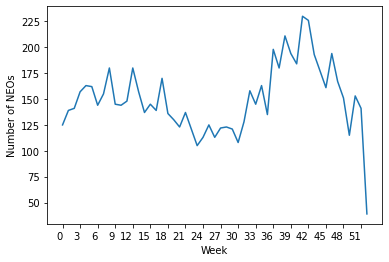

In [48]:
#### Create a line plot of the number of NEOs per week ####

df_NEO_week_number = df_data.groupby('week')['date'].count()

plt.plot(df_NEO_week_number.index, df_NEO_week_number)
plt.xticks(ha='right', ticks=np.arange(0,54,3))
plt.xlabel('Week')
plt.ylabel('Number of NEOs')
plt.savefig('plots/NEO_week_number.pdf')
plt.show()

The above graph shows the line plot of the number of NEOs per week. We can see the number is relatively lower during week 24-30, and higher for week 42-45.

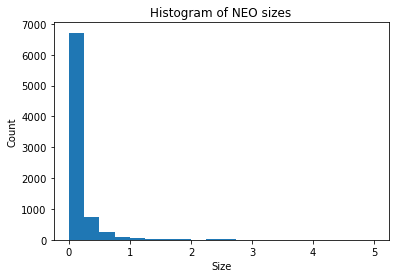

In [49]:
#### Create a histogram of the distribution of NEO sizes #### 

plt.hist(df_data['kilometers estimated_diameter_mean'],bins=20)
plt.title('Histogram of NEO sizes')
plt.xlabel('Size')
plt.ylabel('Count')
plt.savefig('plots/histogram.pdf')
plt.show()

The above graph shows the histogram of the distribution of NEO size. We can see most of the NEO are small under one kilometer, only a few of them are larger than one kilometer or even two kilometers.

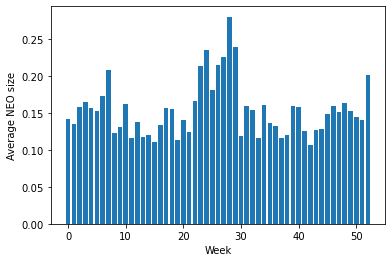

In [50]:
#### Create a bar plot of the average NEO size per week ####

df_NEO_size_week_mean = df_data.groupby('week')['kilometers estimated_diameter_mean'].mean()

plt.bar(df_NEO_size_week_mean.index, df_NEO_size_week_mean)
plt.xlabel('Week')
plt.ylabel('Average NEO size')
plt.savefig('plots/average_neo_size_week.pdf')
plt.show()

The above graph shows the bar plot of the average NEO size per week. We can see the size is relatively larger for week 24-30.

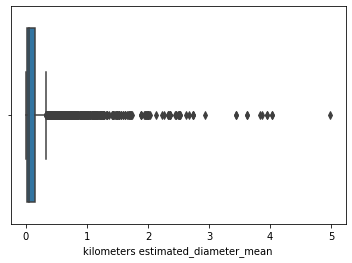

In [51]:
#### Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week ####

sns.boxplot(x=df_data['kilometers estimated_diameter_mean'])
plt.savefig('plots/boxplot.pdf')

The above graph shows the box plot of the mean diameter of the NEO in kilometers. We can see most of the NEO size near zero kilometers.

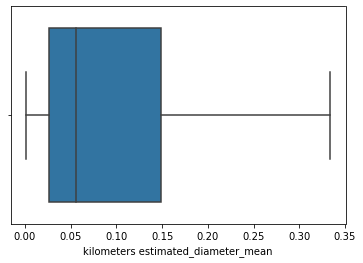

In [52]:
# Boxplot without outliers
sns.boxplot(x=df_data['kilometers estimated_diameter_mean'],showfliers = False)
plt.savefig('plots/boxplot_without_outliers.pdf')

The above graph shows the box plot of the mean diameter of the NEO in kilometers without outliers. We can see all diameters of the NEOs are less than 0.35 kilometers while the mean is around 0.06 kilometers.

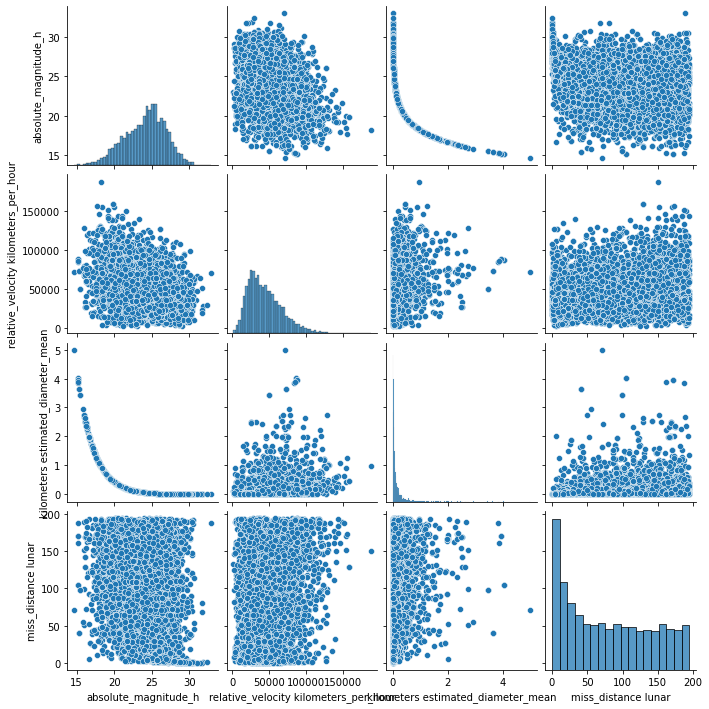

In [53]:
# Testing different feature for correlation
col = ['absolute_magnitude_h','relative_velocity kilometers_per_hour','kilometers estimated_diameter_mean', 'miss_distance lunar']

sns.pairplot(df_data,vars=col)
plt.savefig('plots/pairplot.pdf')

The above graphs shows the correlation between different variables.

### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

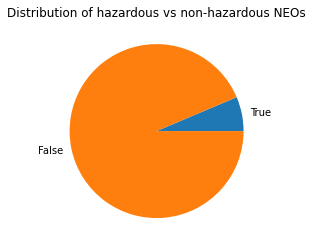

In [54]:
#### Pie chart of the proportion of hazardous vs non-hazardous NEOs ####
labels = ['True', 'False']
counts = [true_count, false_count]

plt.figure(facecolor='white')
plt.pie(counts, labels = labels)
plt.title('Distribution of hazardous vs non-hazardous NEOs')
plt.savefig('plots/pie.pdf')
plt.show() 

The above graph shows the pie chart of the proportion of hazardous and non-hazardous NEOs. We can see there is only a small portion of hazardous NEOs compared with non-hazardous.

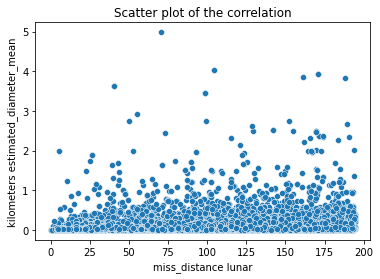

In [55]:
#### Scatter plot of the correlation between NEO size and close approach distance ####

sns.scatterplot(x="miss_distance lunar",y="kilometers estimated_diameter_mean",data=df_data).set(title='Scatter plot of the correlation')
plt.savefig('plots/scatterplot.pdf')

The above graph shows the scatter plot of correlation between NEOs size and close approach distance. We can see they have little correlation.

In [58]:
# Interactive visualizations

fig = px.line( y=df_NEO_size_day_mean, x=df_NEO_size_day_mean.index,title='Size')
fig.show()

The above graph show the relationship between the size and date of NEOs. We can see the size the relatively higher during summer, especially July, with the maximum size of 0.6 kilometers.

In [59]:

fig = px.line( y=df_dis_lunar_min, x=df_dis_lunar_min.index,title='Miss distance (lunar)')
fig.show()

The above graph shows the relationship between the lunar distance and date of NEOs. We can see the distance is larger between late May and late July with maximum of 28.79 kilometers.

In [60]:
px.scatter(df_data, x="miss_distance lunar",y="kilometers estimated_diameter_mean", color="is_potentially_hazardous_asteroid")

The above graph shows the correlation in size and distance of hazardous and non hazardous asteroid. We can see the correlation is so small.

In [61]:
px.scatter(df_data[df_data['miss_distance lunar'] < 65], x="miss_distance lunar",y="kilometers estimated_diameter_mean", color="is_potentially_hazardous_asteroid")

The above graph shows the correlation in size and distance of hazardous and non hazardous asteroid where the distance is less than 65. 

In [69]:
# Get training data for classifier

col = ['miss_distance lunar', 'kilometers estimated_diameter_mean']

df_data_sort = df_data.sort_values('miss_distance lunar')
df_data_sort = df_data[df_data['miss_distance lunar'] < 50]
X = df_data_sort.loc[:,col].values


y=[int(elem) for elem in df_data_sort.loc[:,'is_potentially_hazardous_asteroid']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


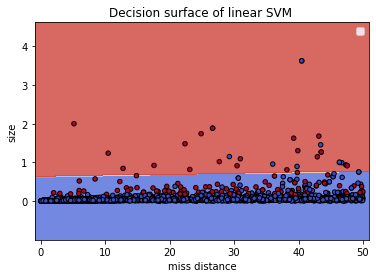

In [76]:

# Rewrite from https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# fit a SVM with a linear kernel
model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVM ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('size')
ax.set_xlabel('miss distance')
ax.set_title(title)
ax.legend()
plt.savefig('plots/svm.pdf')
plt.show()


### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

The above graph shows the linear classification of the NEOs. We can see that the result is bad that we cannot identify the class through the result, since the data are packed and close to each other.

# Results
When looking at the NEOs there is some clear trends in the sommer period. The average NEO size is higher over the summer and the miss distance becomes larger over the summer. When looking at the number of NEOs per week, we can see the number is relatively lower during week 24-30 (sommer), and higher for week 42-45(fall). When looking at the distribution of NEO size. We can see most of the NEO are small under one kilometer, only a few of them are larger than one kilometer or even two kilometers. The NEO size is not correlated with the miss distance.
The mean size of the hazardous asteroid is bigger than the non-hazardous NEOs. It seems that the size of a NEO is correlated with whether it is potentially hazardous.
The correlation between the size of a NEO and whether it is potentially hazardous is 0.26 so almost no correlation.

It is easier to make a classeifier when looking at NEOs there close the earth so we think that more resources need to be allocated to tracking NEOs that are close to the earth.



# Scientific paper

Link to paper: https://www.researchgate.net/publication/285663733_Data_classification_using_support_vector_machine

The paper is about the support vector machine (SVM) used for classification. SVM is supervised learning algorithm for classification and regression and SVM can be used for high-dimensional data. First, the SVM maps the input to high dimensional space and then tries to find the hyperplane that separates the data the best. 
The paper show that SVM can be used in different use cases like heart data, diabetes data, satelilite data and shuttle data. 


- First, we will make a Principal component analysis (PCA) on all the features to only get the significant components.
- Then will use the features to train a classifier using the support vector machine.
- We will use cross validation to find the optimal parameter setting when training the classifier.
- In the end, we have a classier that can classify if the NEO is hazardous or non-hazardous based on the selected features from the PCA analysis.

